# Purpose:

The purpose of this notebook is to demonstrate to my Marketing 201 classmates the ability to utilize machine learning to support marketing efforts.  Below is a machine learning model to predict customer churn.  Keep in mind this model will not involve extensive feature engineering or feature selection as the audience and purpose of this notebook is for simple educational purposes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data

In [2]:
df1 = pd.read_csv('churn raw data.csv')

In [3]:
df1.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [6]:
df1 = df1.drop(['CustomerId','Surname'], axis=1)

In [7]:
numerical_var = list(df1.select_dtypes(np.number).columns)
numerical_var

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

In [8]:
categorical_var = list(df1.select_dtypes(exclude=np.number).columns)
categorical_var

['Geography', 'Gender']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X = df1.drop('Exited', axis=1)
y = df1['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3, stratify=y)

print(f'y_train class balance {y_train.value_counts()}, y_test class balance {y_test.value_counts()}')

y_train class balance 0    6370
1    1630
Name: Exited, dtype: int64, y_test class balance 0    1593
1     407
Name: Exited, dtype: int64


# Feature Engineering Pipeline

In [9]:
from sklearn.pipeline import Pipeline
import feature_engine.encoding as enc

In [12]:
feat_pipe = Pipeline([
    ('enc', enc.OneHotEncoder(variables=categorical_var))
])

X_train = feat_pipe.fit_transform(X_train)
X_test = feat_pipe.transform(X_test)

In [13]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
8510,550,40,8,150490.32,1,0,0,166468.21,1,0,0,1,0
6141,572,24,1,0.00,2,1,1,151460.84,1,0,0,0,1
2037,668,24,7,173962.32,1,0,0,106457.11,0,1,0,1,0
7883,551,45,6,0.00,2,1,1,51143.43,1,0,0,1,0
4377,719,37,9,101455.70,1,1,0,25803.59,1,0,0,1,0


In [14]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Spain,Geography_Germany,Gender_Female,Gender_Male
6913,564,36,7,206329.65,1,1,1,46632.87,1,0,0,1,0
6439,632,37,1,138207.08,1,1,0,60778.11,0,1,0,0,1
5601,704,44,9,153656.85,1,1,0,158742.81,0,1,0,1,0
1376,457,41,8,73700.12,3,1,1,185750.02,1,0,0,0,1
8321,586,64,1,0.00,2,1,1,53710.23,1,0,0,0,1


# Classification Model

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold
from scipy import stats

In [22]:
%%time

clf = XGBClassifier(n_jobs=-1)

params = {
    'n_estimators': stats.randint(200,(1500-200)),
    'max_depth': stats.randint(1,(20-1)),
    'learning_rate': stats.uniform(0.0001,(0.5-0.0001)),
    'gamma': stats.uniform(0.0001,(10-0.0001)),
    'subsample': stats.uniform(0.5,(1-0.5))
}

cv = RepeatedStratifiedKFold(n_splits=8, n_repeats=2)

rand_search = RandomizedSearchCV(estimator=clf, param_distributions=params, cv=cv, n_iter=3, n_jobs=-1, scoring='roc_auc')

rand_search.fit(X_train,y_train)

print(f'Best Score: {rand_search.best_score_:.3f}')
print(f'Best Params: {rand_search.best_params_}')

C:\Users\JB\anaconda3\envs\DataScienceEnvPy3912\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\JB\anaconda3\envs\DataScienceEnvPy3912\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:30:44] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Score: 0.842
Best Params: {'gamma': 0.6100734371652002, 'learning_rate': 0.0128869345143102, 'max_depth': 18, 'n_estimators': 919, 'subsample': 0.7518445147241132}
CPU times: total: 2min 4s
Wall time: 6min 58s


In [24]:
xgbc = XGBClassifier(n_jobs=-1, **rand_search.best_params_)

xgbc.fit(X_train,y_train)

C:\Users\JB\anaconda3\envs\DataScienceEnvPy3912\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\JB\anaconda3\envs\DataScienceEnvPy3912\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:33:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.6100734371652002, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.0128869345143102,
              max_delta_step=0, max_depth=18, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=919, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.7518445147241132, tree_method='exact',
              validate_parameters=1, verbosity=None)

# Model Evaluation

In [25]:
y_pred = xgbc.predict(X_test)

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

Text(0.5, 69.0, 'Predicted Labels')

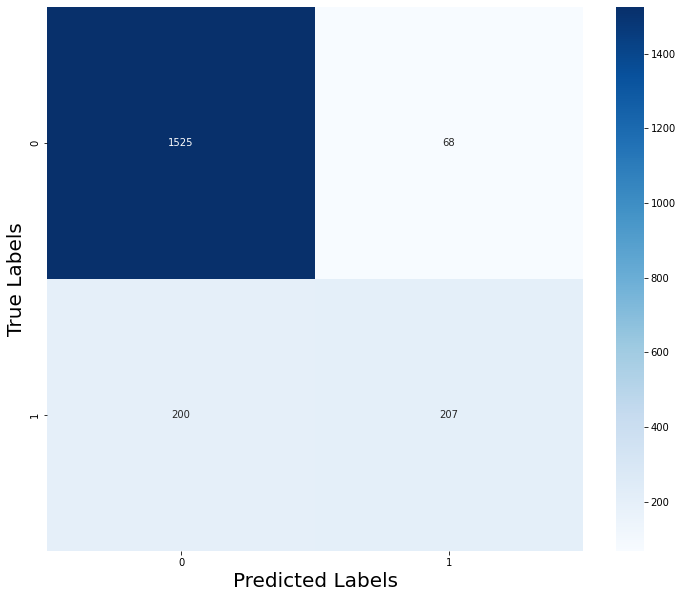

In [31]:
cm = confusion_matrix(y_test,y_pred)

plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.ylabel('True Labels', fontsize=20)
plt.xlabel('Predicted Labels',fontsize=20)

In [33]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.75      0.51      0.61       407

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.86      2000

